In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("Large_Mobile_Dataset.csv")
df.drop(columns=["Android"],inplace=True)

In [3]:
df.head()

,Processor,Brand,Ram_GB,Rom_GB,Battery_Capacity,Display_Quality,Version,Price
0,MediaTek,vivo,12,256,6500,AMOLED,15,54999
1,Snapdragon,vivo,8,128,7300,AMOLED,15,21950
2,MediaTek,vivo,6,128,6500,LCD,15,13999
3,Samsung,Samsung,8,128,4700,AMOLED,14,37948
4,Samsung,Samsung,6,128,5000,AMOLED,15,17499


In [4]:
x=df["Ram_GB"].value_counts()
x

Ram_GB
8     753
4     439
6     377
12    267
3     142
2      70
16     33
1      11
24      1
10      1
18      1
Name: count, dtype: int64

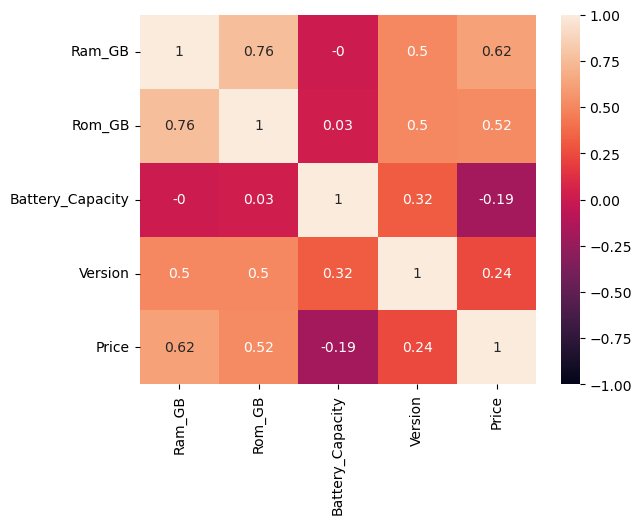

In [5]:
cor = df.select_dtypes(["int64","float64"]).corr().round(2)
sns.heatmap(cor,annot=True,vmin=-1, vmax=1);

In [6]:
target ="Price"
X = df.drop(columns=target)
y = df[target]

print(X.shape)
print(y.shape)

(2095, 7)
(2095,)


In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape

(1676, 7)

In [8]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # This keeps numerical columns unchanged
)

In [9]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

# Define pipeline
model = make_pipeline(
    preprocessor,
    XGBRegressor(objective='reg:squarederror', random_state=42)
)
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [3, 5, 7, 10],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__gamma': [0, 0.1, 0.2],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'xgbregressor__reg_lambda': [1, 1.5, 2]     # L2 regularization
}
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=1,
    scoring='r2',  # or 'r2', 'neg_mean_absolute_error'
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)  # if using neg RMSE


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1, 'xgbregressor__reg_alpha': 0.01, 'xgbregressor__n_estimators': 300, 'xgbregressor__max_depth': 7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__gamma': 0.2, 'xgbregressor__colsample_bytree': 0.8}
Best CV Score: 0.8933950304985047


In [107]:
scores = cross_val_score(random_search, X_train, y_train, cv=5)  

print("Cross-validation scores (R²):", scores)
print("Mean R² score:", np.mean(scores))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Cross-validation scores (R²): [0.93469977 0.88426375 0.885692   0.80180287 0.94622236]
Mean R² score: 0.8905361533164978


In [10]:
model = make_pipeline(
    preprocessor,
    XGBRegressor(objective='reg:squarederror', random_state=42,
                subsample=1,reg_alpha=0.1,n_estimators=300,max_depth=7,learning_rate=0.1,gamma=0.2,colsample_bytree=1.0)
)
model.fit(X_train,y_train)

,steps,"[('columntransformer', ...), ('xgbregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
scores = cross_val_score(model, X_train, y_train, cv=5)  

print("Cross-validation scores (R²):", scores)
print("Mean R² score:", np.mean(scores))

Cross-validation scores (R²): [0.93385655 0.86217844 0.90536076 0.87591678 0.95746636]
Mean R² score: 0.9069557785987854


In [12]:
model.score(X_test,y_test)

0.9284047484397888

In [13]:
model.score(X_train,y_train)

0.9787797927856445

In [116]:
import joblib

joblib.dump(model, 'Xgboost_price_predictor.pkl')


['Xgboost_price_predictor.pkl']

In [17]:
model_recommend = make_pipeline(
    preprocessor,
    NearestNeighbors(n_neighbors=5,metric='cosine')
)
model_recommend.fit(X)  


,steps,"[('columntransformer', ...), ('nearestneighbors', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
def recommend_similar_phones(user_input: dict):
    """
    Recommends top 5 similar phones based on user_input specs.
    """
    user_df = pd.DataFrame([user_input])
    user_encoded = preprocessor.transform(user_df)
    distances, indices = model_recommend.named_steps['nearestneighbors'].kneighbors(user_encoded)
    similar_phones = X.iloc[indices[0]].copy()

    return similar_phones


In [25]:
user_input = {
    "Processor": "Snapdragon 888",
    "Brand": "Samsung",
    "Ram_GB": 8,
    "Rom_GB": 128,
    "Battery_Capacity": 4500,
    "Display_Quality": "AMOLED",
    "Version": 12
}

recommend_similar_phones(user_input)


,Processor,Brand,Ram_GB,Rom_GB,Battery_Capacity,Display_Quality,Version
1539,Snapdragon,Samsung,8,128,4500,AMOLED,12
1497,Samsung,Samsung,8,128,4500,AMOLED,12
31,Samsung,Samsung,8,128,4500,AMOLED,12
73,Snapdragon,Samsung,8,128,4500,AMOLED,12
22,Samsung,Samsung,8,128,4500,AMOLED,13
